# Modeling Calcium Fluorescences

This tutorial will provide an introduction to using recent deep learning methods for analyzing data beyond simple classification problems. In particular, we will look at how to build a generative model to characterize the "spike inferrence" task common in calcium imaging. This tutorial will use the [Spikefinder](http://spikefinder.codeneuro.org/) dataset, which contains a collection of calcium imaging fluorescences and the associated observed spikes.

In [1]:
# First, let's load all the dependencies we will need.
# The utils module contains all the functions for loading
# and processing data; this tutorial will focus on building
# the deep learning models.

from __future__ import division
from __future__ import print_function

import os
import sys

from imp import reload
import utils; reload(utils)

import keras
import numpy as np
import matplotlib.pyplot as plt

# Checks that you've got Keras 2.0.0 installed (for compatibility).
assert keras.__version__ == '2.0.2', 'Invalid Keras version.'

Using TensorFlow backend.


Let's use matplotlib to plot samples from the data.

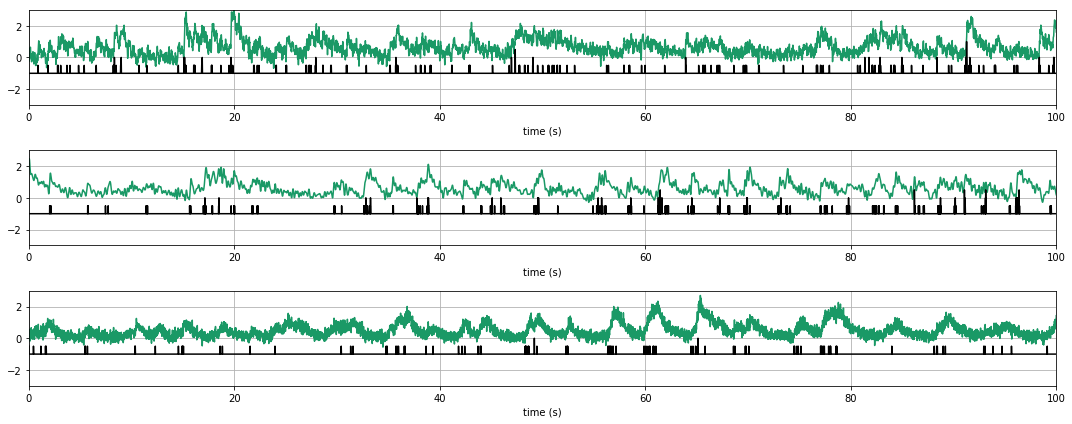

In [2]:
# Plots the first 5 samples.
fig = plt.figure(figsize=(15, 6))
for i, (c, s) in zip(range(1, 4), utils.iterate_files()):
    plt.subplot(3, 1, i)
    utils.plot_sample(c['0'], s['0'])

plt.tight_layout()
plt.show()

del i, c, s

Now that we've got an idea of what the data looks like, let's parse a dataset. We will partition the calcium fluorescences into two parts: the part where there is at least one spike in an N-bin range, and the part where there isn't.

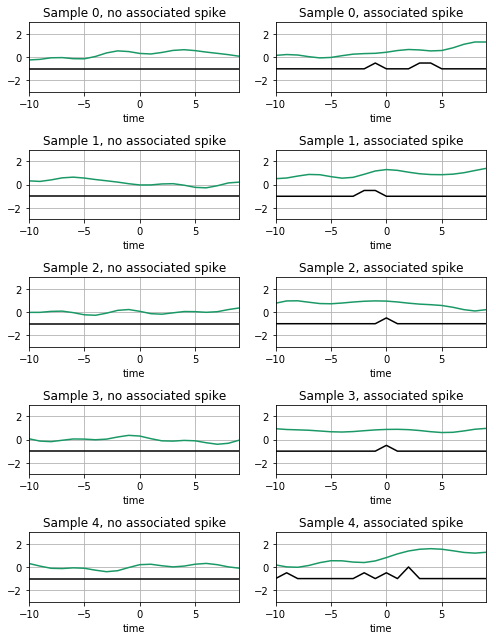

In [3]:
# Gets five examples of each type.
yes_cal, no_cal, yes_spikes, no_spikes = [], [], [], []
for calcium, spikes, did_spike in utils.partition_data(10, spike_n=1):
    if did_spike:
        yes_cal.append(calcium)
        yes_spikes.append(spikes)
    else:
        no_cal.append(calcium)
        no_spikes.append(spikes)
    
    if len(yes_spikes) > 5 and len(no_spikes) > 5:
        break

# Plot the data where no spike was observed on the left,
# and the data where a spike was observed on the right.
fig = plt.figure(figsize=(7, 9))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    utils.plot_sample(no_cal[i], no_spikes[i], t_start=-10, t_end=9, sampling_rate=1)
    plt.title('Sample %d, no associated spike' % i)
    plt.subplot(5, 2, 2 * i + 2);
    utils.plot_sample(yes_cal[i], yes_spikes[i], t_start=-10, t_end=9, sampling_rate=1)
    plt.title('Sample %d, associated spike' % i)

plt.tight_layout()
plt.show()

del yes_cal, no_cal, yes_spikes, no_spikes

Great! Now we've got a way of splitting the dataset into "spike observed" and "no spike observed" points. Let's split all the data up this way, and put them in Numpy arrays so that we can build our model. Since we just care about whether or not a spike was observed at the current timestep, we'll ignore the spike trace. Additionally, let's cache the Numpy arrays somewhere on disk so that we don't have to worry about regenerating the dataset every time we want to use it (since this operation can be kind of slow).

In [4]:
calcium, did_spike = utils.load_dataset()
print('Size of the dataset:')
print('    calcium: %d samples of length %d' % (calcium.shape[0], calcium.shape[1]))
print('    did_spike: %d samples' % did_spike.shape[0])

del calcium, did_spike

Size of the dataset:
    calcium: 514860 samples of length 20
    did_spike: 514860 samples


Great, now all of our data preprocessing is done. Let's get into the specifics of the model. First, we'll build a recurrent neural network classifier and see how well it does. Next, we'll build a [Variational Autoencoder](https://arxiv.org/abs/1606.05908) to build an unsupervised model of the data (in other words, a model that doesn't know if the calcium fluorescence corresponded to a spike).

In [5]:
def build_model(input_len):
    input_calcium = keras.layers.Input(shape=(input_len,), name='input_calcium')
    
    # This adds some more features that the model can use.
    calcium_rep = keras.layers.Reshape((input_len, 1))(input_calcium)
    calcium_delta = utils.DeltaFeature()(calcium_rep)
    calcium_quad = utils.QuadFeature()(calcium_rep)
    calcium_delta_quad = utils.QuadFeature()(calcium_delta)
    x = keras.layers.Concatenate()([calcium_rep, calcium_delta, calcium_quad])
    
    # This is the single LSTM layer that performs the classification.
    x = keras.layers.LSTM(64, return_sequences=False)(x)
    
    output_pred = keras.layers.Dense(1)(x)
    model = keras.models.Model(inputs=[input_calcium], outputs=[output_pred])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

def get_evenly_split_dataset(num_samples):
    """Gets an evenly-split sample of the data."""
    
    calcium, did_spike = utils.load_dataset()

    spike_idxs = np.arange(calcium.shape[0])[did_spike == 1]
    nospike_idxs = np.arange(calcium.shape[0])[did_spike == 0]
    spike_idxs = np.random.choice(spike_idxs, num_samples // 2)
    nospike_idxs = np.random.choice(nospike_idxs, num_samples // 2)
    idxs = np.concatenate([spike_idxs, nospike_idxs])

    return calcium[idxs], did_spike[idxs]

NUM_LSTM_TRAIN = 10000
calcium, did_spike = get_evenly_split_dataset(NUM_LSTM_TRAIN)
model = build_model(calcium.shape[1])

# Trains the model for a single pass.
model.fit([calcium], [did_spike], epochs=5, verbose=2)
print('Done')

Epoch 1/5
9s - loss: 0.6198 - acc: 0.6800
Epoch 2/5
9s - loss: 0.5904 - acc: 0.6943
Epoch 3/5
9s - loss: 0.5762 - acc: 0.7093
Epoch 4/5
8s - loss: 0.5777 - acc: 0.7110
Epoch 5/5
8s - loss: 0.5800 - acc: 0.7070
Done


Let's also print a confusion matrix so we can get a bit more information about how the model performed.

In [6]:
preds = model.predict(calcium)
p_s, p_n = preds[did_spike == 1], preds[did_spike == 0]
n_total = calcium.shape[0]

# Computes confusion matrix values.
ss, ns = np.sum(p_s > 0.5) / n_total, np.sum(p_s <= 0.5) / n_total
sn, nn = np.sum(p_n > 0.5) / n_total, np.sum(p_n <= 0.5) / n_total

print('                     spike    no spike')
print('predicted spike    | %.3f  | %.3f' % (ss, ns))
print('predicted no spike | %.3f  | %.3f' % (sn, nn))

                     spike    no spike
predicted spike    | 0.354  | 0.146
predicted no spike | 0.144  | 0.356


The model does't perform that great; spike inferrence is clearly a hard problem. Let's take a look at some of the misclassifications.

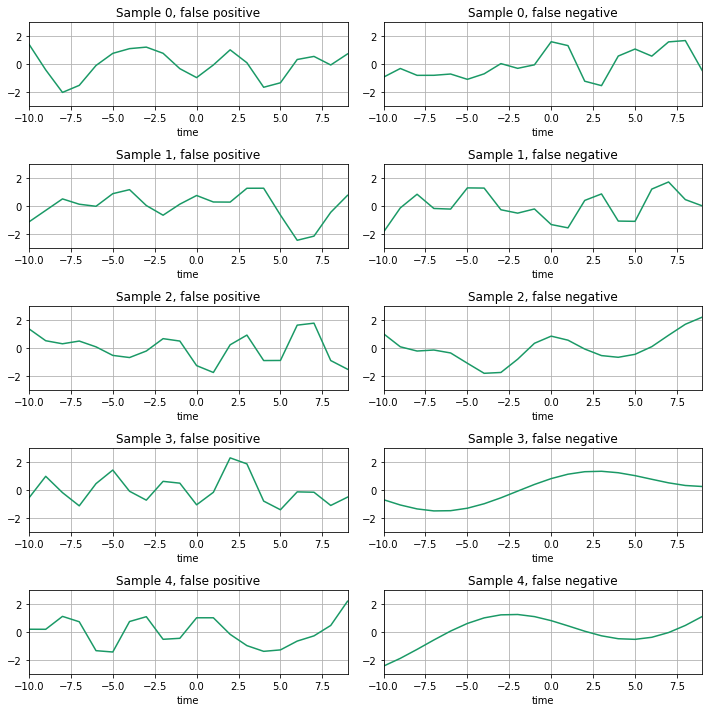

In [7]:
plt.figure(figsize=(10, 10))

# Gets the false positives and false negatives.
c_s, c_n = calcium[did_spike == 1, :], calcium[did_spike == 0, :]
p_sf, p_nf = np.squeeze(p_s), np.squeeze(p_n)
ns_calc, sn_calc = c_s[p_sf <= 0.5], c_n[p_nf > 0.5]

d = calcium.shape[1] / 2
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    utils.plot_sample(calcium=ns_calc[i],
                      t_start=-d,
                      t_end=d - 1,
                      sampling_rate=1)
    plt.title('Sample %d, false positive' % i)
    
    plt.subplot(5, 2, 2 * i + 2)
    utils.plot_sample(calcium=sn_calc[i],
                      t_start=-d,
                      t_end=d - 1,
                      sampling_rate=1)
    plt.title('Sample %d, false negative' % i)

plt.tight_layout()
plt.show()